In [ ]:
 # Installing required packages
!pip install pyspark
!pip install findspark
!pip install pyarrow==1.0.0
!pip install pandas
!pip install numpy==1.19.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 51.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This err

In [ ]:
import findspark
findspark.init()
import pandas as pd
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.functions import avg

# Initing spark session

In [ ]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Big-Data-Assignment-2") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
spark

# Pre-Processing

In [ ]:
# Read data
data = pd.read_csv("egphotelbookings.csv")
data.head()


,Unnamed: 0,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Renaissance Hotel,0,342,2018,July,27,1,0,0,...,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0
1,1,Renaissance Hotel,0,737,2018,July,27,1,0,0,...,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0
2,2,Renaissance Hotel,0,7,2018,July,27,1,0,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0
3,3,Renaissance Hotel,0,13,2018,July,27,1,0,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0
4,4,Renaissance Hotel,0,14,2018,July,27,1,0,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1


In [ ]:
data.rename(columns = {'Unnamed: 0':'id'}, inplace = True)

In [ ]:
# convert data to spark
sdf = spark.createDataFrame(data)
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- hotel: string (nullable = true)
 |-- is_canceled: long (nullable = true)
 |-- lead_time: long (nullable = true)
 |-- arrival_date_year: long (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: long (nullable = true)
 |-- arrival_date_day_of_month: long (nullable = true)
 |-- stays_in_weekend_nights: long (nullable = true)
 |-- stays_in_week_nights: long (nullable = true)
 |-- adults: long (nullable = true)
 |-- children: double (nullable = true)
 |-- babies: long (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: long (nullable = true)
 |-- previous_cancellations: long (nullable = true)
 |-- previous_bookings_not_canceled: long (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)
 |-- booking_changes: long (nullable = 

In [ ]:
#found nan values in agent , company (most of it nan) so we can drop it just in case it conflict with anything later on
#droping company
sdf = sdf.drop("company")
#handle nan values in agent using mean
sdf = sdf.na.fill(value=0,subset=["agent"])
# removing the rows with undefined vlues in the meal column
sdf = sdf.filter(col("meal") != "Undefined")

#) Handle duplicates
sdf = sdf.dropDuplicates()


In [ ]:
# Create new derived columns: Total stay duration, Season and Total guests.
sdf = sdf.withColumn("total_stay_duration", sdf["stays_in_weekend_nights"] + sdf["stays_in_week_nights"])
# season(Winter, Spring, Summer, Fall)
sdf = sdf.withColumn("season", when(sdf["arrival_date_month"].isin(["December", "January", "February"]), "Winter") \
                                 .when(sdf["arrival_date_month"].isin(["March", "April", "May"]), "Spring") \
                                 .when(sdf["arrival_date_month"].isin(["June", "July", "August"]), "Summer") \
                                 .otherwise("Fall")) # Chain when and otherwise for a single expression
# total guests
sdf = sdf.withColumn("total_guests", sdf["adults"] + sdf["children"] + sdf["babies"])

In [ ]:
# drop booking , Needed if something we missied in preprocessing
spark.sql("DROP TABLE IF EXISTS bookings")

DataFrame[]

In [ ]:
sdf.createTempView("bookings")


# Queries Using SparkSQL

In [ ]:
#Explore the data well
spark.sql("SELECT * FROM bookings").show()

+----+-----------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+--------------------+---------------+------+---------------------------+-------------------------+-------------------+------+------------+
|  id|            hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|days_in_waiting_list|  customer_type|   adr|required_car_parking_spaces|total_of_special_requests|t

In [ ]:
# Compute the cancellation rate as (number of cancellations / total bookings)*100 per country, and
# list the top five countries have the highest cancellation rates.
spark.sql("SELECT country, AVG(is_canceled) * 100 AS cancellation_rate FROM bookings GROUP BY country ORDER BY cancellation_rate DESC LIMIT 5").show()


+-------+-----------------+
|country|cancellation_rate|
+-------+-----------------+
|    KHM|            100.0|
|    IMN|            100.0|
|    JEY|            100.0|
|    NIC|            100.0|
|    BEN|            100.0|
+-------+-----------------+



In [ ]:
# Identify which season (Winter, Spring, Summer, Fall) has the highest cancellation rate for
# bookings with lead time > 100 days. (Define seasons based on arrival_date_month)
spark.sql("SELECT season, AVG(is_canceled) * 100 AS cancellation_rate FROM bookings WHERE lead_time > 100 GROUP BY season ORDER BY cancellation_rate DESC LIMIT 1").show()

+------+------------------+
|season| cancellation_rate|
+------+------------------+
|Winter|60.533255200703195|
+------+------------------+



In [ ]:
# Which reserved room types experience the highest mismatch with the assigned room type?
# (Where they differ).
spark.sql("SELECT reserved_room_type, assigned_room_type, COUNT(*) AS mismatch_count FROM bookings WHERE reserved_room_type != assigned_room_type GROUP BY reserved_room_type, assigned_room_type ORDER BY mismatch_count DESC LIMIT 1").show()

+------------------+------------------+--------------+
|reserved_room_type|assigned_room_type|mismatch_count|
+------------------+------------------+--------------+
|                 A|                 D|          7492|
+------------------+------------------+--------------+



In [ ]:
# Which distribution channel shows the lowest cancellation rate and what is its average revenue per
# booking (ADR x total nights)?
spark.sql("SELECT distribution_channel, AVG(is_canceled) * 100 AS cancellation_rate, AVG(adr * total_stay_duration) AS avg_revenue_per_booking FROM bookings GROUP BY distribution_channel ORDER BY cancellation_rate ASC LIMIT 1").show()

+--------------------+------------------+-----------------------+
|distribution_channel| cancellation_rate|avg_revenue_per_booking|
+--------------------+------------------+-----------------------+
|              Direct|17.506262176454214|       371.206956582243|
+--------------------+------------------+-----------------------+



In [ ]:
# Which meal types are most common among bookings with more than 3 total guests?
spark.sql("SELECT meal, COUNT(*) AS booking_count FROM bookings WHERE total_guests > 3 GROUP BY meal ORDER BY booking_count DESC").show()

+----+-------------+
|meal|booking_count|
+----+-------------+
|  BB|         3428|
|  HB|          597|
|  SC|           26|
|  FB|           21|
+----+-------------+



# Using Spark DataFrame

In [ ]:
sdf.groupBy("country") \
   .agg((avg("is_canceled") * 100).alias("cancellation_rate")) \
   .orderBy(col("cancellation_rate").desc()) \
   .limit(5) \
   .show()

+-------+-----------------+
|country|cancellation_rate|
+-------+-----------------+
|    KHM|            100.0|
|    IMN|            100.0|
|    JEY|            100.0|
|    NIC|            100.0|
|    BEN|            100.0|
+-------+-----------------+



In [ ]:
sdf.filter(col("lead_time") > 100) \
   .groupBy("season") \
   .agg((avg("is_canceled") * 100).alias("cancellation_rate")) \
   .orderBy(col("cancellation_rate").desc()) \
   .limit(1) \
   .show()

+------+------------------+
|season| cancellation_rate|
+------+------------------+
|Winter|60.533255200703195|
+------+------------------+



In [ ]:
sdf.filter(col("reserved_room_type") != col("assigned_room_type")) \
   .groupBy("reserved_room_type", "assigned_room_type") \
   .count() \
   .orderBy(col("count").desc()) \
   .limit(1) \
   .show()

+------------------+------------------+-----+
|reserved_room_type|assigned_room_type|count|
+------------------+------------------+-----+
|                 A|                 D| 7492|
+------------------+------------------+-----+



In [ ]:
sdf.groupBy("distribution_channel") \
   .agg((avg("is_canceled") * 100).alias("cancellation_rate"),
        avg(col("adr") * col("total_stay_duration")).alias("avg_revenue_per_booking")) \
   .orderBy(col("cancellation_rate").asc()) \
   .limit(1) \
   .show()

+--------------------+------------------+-----------------------+
|distribution_channel| cancellation_rate|avg_revenue_per_booking|
+--------------------+------------------+-----------------------+
|              Direct|17.506262176454214|       371.206956582243|
+--------------------+------------------+-----------------------+



In [ ]:
sdf.filter(col("total_guests") > 3) \
   .groupBy("meal") \
   .count() \
   .orderBy(col("count").desc()) \
   .show()

+----+-----+
|meal|count|
+----+-----+
|  BB| 3428|
|  HB|  597|
|  SC|   26|
|  FB|   21|
+----+-----+



# Visuliazing


<Figure size 1000x600 with 0 Axes>

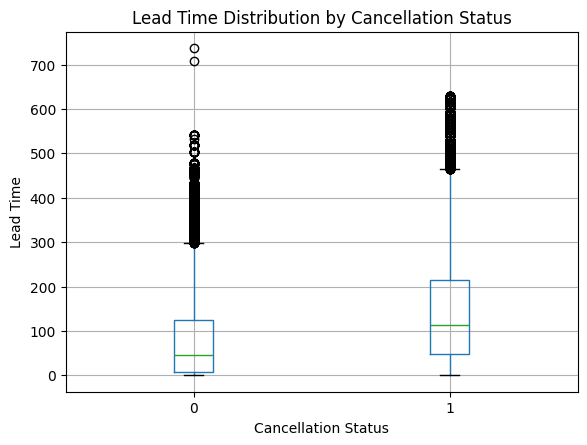

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt


lead_time_cancellation = sdf.select("lead_time", "is_canceled")

#Convert to Pandas DataFrame for plotting
lead_time_cancellation_pd = lead_time_cancellation.toPandas()

# boxplot
plt.figure(figsize=(10, 6))
lead_time_cancellation_pd.boxplot(column='lead_time', by='is_canceled')
plt.xlabel("Cancellation Status")
plt.ylabel("Lead Time")
plt.title("Lead Time Distribution by Cancellation Status")
plt.suptitle("")
plt.show()


# The data shows that cancellations are rare for lead times up to around 400, but they increase noticeably as lead time exceeds 400.